# SchW-BERT-GAN ファインチューニング
- 事前学習済みのモデルを使用したSchW-BERT-GAN用のモジュールの定義
    - body選択
    - SchwBertGenerator
    - SchwBertDiscriminator
- SchW-BERT-GANのファインチューニングの実施
    - ファインチューニング用関数を作成
    - 事前学習済みのものと比較
- SchW-BERT-GANによる音楽自動生成
    - コードをデータセットからランダムに選んできて生成

WGAN-gpの実装は[eriklindernoren/PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py)が参考になる  
他にもいろいろPytorchのGANが実装されてる

In [1]:
import os, glob, copy, time, math
visible_devices = [2,3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import random_split
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from pypianoroll import Track, Multitrack
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, count_params, grid_plot
from bundle import Bundle
from preprocess.original import load_bundle_list
from dataloader import TheorytabDataset, TheorytabDataLoader
from modules.model import gelu, save_body, load_body, make_body
from modules.multi_gpu import MultiGPUWrapper
from modules.save_and_load import save_config, load_config, save_model, load_model

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

current dir: /root/schwbert
20/32 cpus are available.


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

dataset_dir = os.path.join(base_dir, "theorytab")
input_csv = os.path.join(dataset_dir, "theorytab.csv")
input_dir = os.path.join(dataset_dir, "pianoroll")

output_base_dir = os.path.join(schwbert_dir, "models")
output_dir = os.path.join(output_base_dir, "theorytab")

for directory in [schwbert_dir, output_base_dir, output_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

### Configのロード

In [3]:
def select_config(directory, postfix=".json", fixed_number=None):
    config_paths = glob.glob(os.path.join(directory, f"*{postfix}"))
    config_paths.sort()
    if len(config_paths) > 1:
        print(f"{len(config_paths)} models found in {directory}")
        for i, path in enumerate(config_paths):
            print(f"{i}: {path.split('/')[-1]}")
        if fixed_number is None:
            config_path = config_paths[int(input("input the number of config:"))]
        else:
            config_path = config_paths[fixed_number]
    else:
        config_path = config_paths[0]
    
    config_name = config_path.split('/')[-1]
    print(f"config is loaded from {config_name}")
    config = load_config(config_name, directory)
    return AttrDict(config)

In [4]:
config = select_config(output_dir, fixed_number=2)
config.noise_size = 100
config.dtt = 5
config.gtt = 10
config.gp_lambda = 10
print(config)

3 models found in ../datasets/schwbert/models/theorytab
0: schwbert_mnp:config@2019-11-24_07:41.json
1: schwbert_mnp:config@2019-11-24_08:38.json
2: schwbert_msp_mnp:config@2019-11-24_10:07.json
config is loaded from schwbert_msp_mnp:config@2019-11-24_10:07.json
AttrDict({'nickname': 'schwbert_msp_mnp', 'step_num': 768, 'beat_resolution': 12, 'beats_in_bar': 4, 'bar_num': 16, 'include_rest_to_area': False, 'melody_pitch_range': [0, 24], 'melody_rest_id': 24, 'melody_mask_id': 25, 'melody_pad_id': 26, 'melody_vocab_size': 27, 'chord_pad_id': 4096, 'chord_vocab_size': 4097, 'fact_size': 16, 'hidden_size': 256, 'intermediate_size': 1024, 'attention_layer_num': 3, 'attention_head_num': 8, 'share_all_bert_params': True, 'dropout_prob': 0.1, 'adam_lr': 1e-05, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'pre_mnp_aug': 2, 'pre_mnp_rate': 0.15, 'pre_mnp_mask_rate': 0.8, 'pre_mnp_random_rate': 0.1, 'pre_mnp_keep_rate': 0.1, 'state_names': {'embeddings': 'schwbert_msp_mnp:ConditionalEmbeddings:E=010H

### データのロード

In [5]:
with Timer():
     bundle_list = load_bundle_list(input_csv, input_dir, core_num=core_num)

start preprocessing...
unpacking result bundles list...
Preprocessing Finished!
load 17396 bundles
0 error(s) occured
22.926353


In [6]:
dataset = TheorytabDataset(bundle_list)
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))

8698


# SchW-BERT-GAN用のモジュールの定義
- SchwBertGenerator*
    - NoiseEmbedding*
        - ノイズベクトルシーケンス→Dense
    - ConditionalBertBody
    - Denseをかけ，メロディを出力
- SchwBertDiscriminator*
    - ConditionalBertBody
    - Denseを縦横にかけ，本物と偽物を区別するよう2値分類

✳︎ついてるやつが新規作成モジュール

## 各種Embeddingsの実装
偽物のmax通したやつは誤差が伝搬しないのでベクトルシーケンスを入力に取りたい  
本物データにはOneHotになってもらう

In [7]:
class NoiseEmbedding(nn.Module):
    def __init__(self, config, noise_size, output_size, pad_id, include_rest=True):
        super(NoiseEmbedding, self).__init__()
        self.config = config
        self.noise_size = noise_size
        self.pad_id = pad_id
        self.include_rest = include_rest
        self.embedding = nn.Linear(noise_size, output_size, bias=False)
    
    def forward(self, input_ids, get_noise=False):
        # input_tesorはデバイス，サイズ，pad箇所の取得用(なのでchordを使う)
        device = input_ids.device
        batch_size, seq_len = input_ids.shape
        
        # ノイズを作成
        noise_vec_seq = torch.randn(batch_size, seq_len, self.noise_size)
        
        # PADのステップを0にする
        noise_vec_seq[input_ids == self.pad_id] = 0
        
        # ノイズの埋め込み表現を得る
        noise_vec_seq = noise_vec_seq.to(device)
        embedding = self.embedding(noise_vec_seq)
        
        # PAD，Maskの音程を0にする．選択式で休符も0にする
        embedding[:, :, self.config.melody_pad_id] = 0
        embedding[:, :, self.config.melody_mask_id] = 0
        if not self.include_rest:
            embedding[:, self.config.melody_rest_id] = 0
        
        if get_noise:
            return embedding, noise_vec_seq
        else:
            return embedding

動作確認

In [8]:
batch = dataloader()
noise_embedding = NoiseEmbedding(config, config.noise_size, config.melody_vocab_size, config.chord_pad_id)
noise_emb = noise_embedding(batch.chord)

print("noise_embedding:", noise_emb.shape)
print(noise_emb[0][0])
print(noise_emb[0][-1])

noise_embedding: torch.Size([2, 768, 27])
tensor([-7.1256e-01, -4.9129e-01, -6.2565e-01,  1.3009e-01, -3.5774e-03,
        -8.3633e-02,  3.6110e-03,  7.2030e-01,  8.6438e-02, -7.5543e-02,
        -3.7902e-01, -2.4820e-01, -8.1938e-01,  7.0299e-02, -4.2658e-01,
         1.4146e-01, -1.6577e+00, -5.5181e-02, -7.7596e-02,  1.4472e-03,
         9.1998e-01,  3.5486e-01,  4.2476e-01,  4.9712e-01,  9.7987e-01,
         0.0000e+00,  0.0000e+00], grad_fn=<SelectBackward>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], grad_fn=<SelectBackward>)


## SchWBertGeneratorの実装

In [8]:
class GELU(nn.Module):
    def forward(self, input_tensor):
        return gelu(input_tensor)

class Softmax(nn.Module):
    # なんかnn.Softmaxはinplace errorとかいうのが発生するので自前でSoftmaxを実装
    def __init__(self, dim):
        super(Softmax, self).__init__()
        self.dim = dim
    
    def forward(self, input_tensor):
        output = torch.exp(input_tensor)
        output = output / output.sum(dim=self.dim).unsqueeze(-1)
        return output

In [10]:
rand = torch.rand(3)
print(rand)
print(Softmax(dim=-1)(rand))
print(nn.Softmax(dim=-1)(rand))

tensor([0.9807, 0.9048, 0.0151])
tensor([0.4334, 0.4017, 0.1650])
tensor([0.4334, 0.4017, 0.1650])


In [9]:
class SchWBertGenerator(nn.Module):
    def __init__(self, config, body):
        super(SchWBertGenerator, self).__init__()
        self.config = config
        self.chord_pad_id = config.chord_pad_id
        self.melody_pad_id = config.melody_pad_id
         
        self.noise_embedding = NoiseEmbedding(config, config.noise_size, config.melody_vocab_size, self.chord_pad_id)
        self.body = body
        
        self.head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            GELU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            GELU(),
            nn.Linear(config.hidden_size, config.melody_vocab_size),
            LayerNorm(config.melody_vocab_size, eps=1e-8),
            GELU(),
            Softmax(dim=-1),
        )
    
    def forward(self, condition_tensor, get_all_outputs=False, get_probs=False):
        
        noise_emb = self.noise_embedding(condition_tensor)
        
        if get_probs:
            body_output, probs = self.body(noise_emb, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(noise_emb, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output
        
        output = self.head(output)

        is_padded = (condition_tensor == self.chord_pad_id)
        ext_is_padded = torch.zeros_like(output, dtype=bool)
        ext_is_padded[:, :, self.melody_pad_id] = is_padded

        output[is_padded] = 0.0
        output[ext_is_padded] = 1.0
                
        if get_all_outputs:
            output = body_output + output
        
        if get_probs:
            return output, probs
        else:
            return output
    
    def to_ids(self, output_map):
        probs, preds = torch.max(output_map, dim=-1)
        return preds

動作確認

In [10]:
batch = dataloader()

In [12]:
g_body = make_body(config)
G = SchWBertGenerator(config, g_body)
g_out = G(batch.chord)
print(g_out.shape)

torch.Size([2, 768, 27])


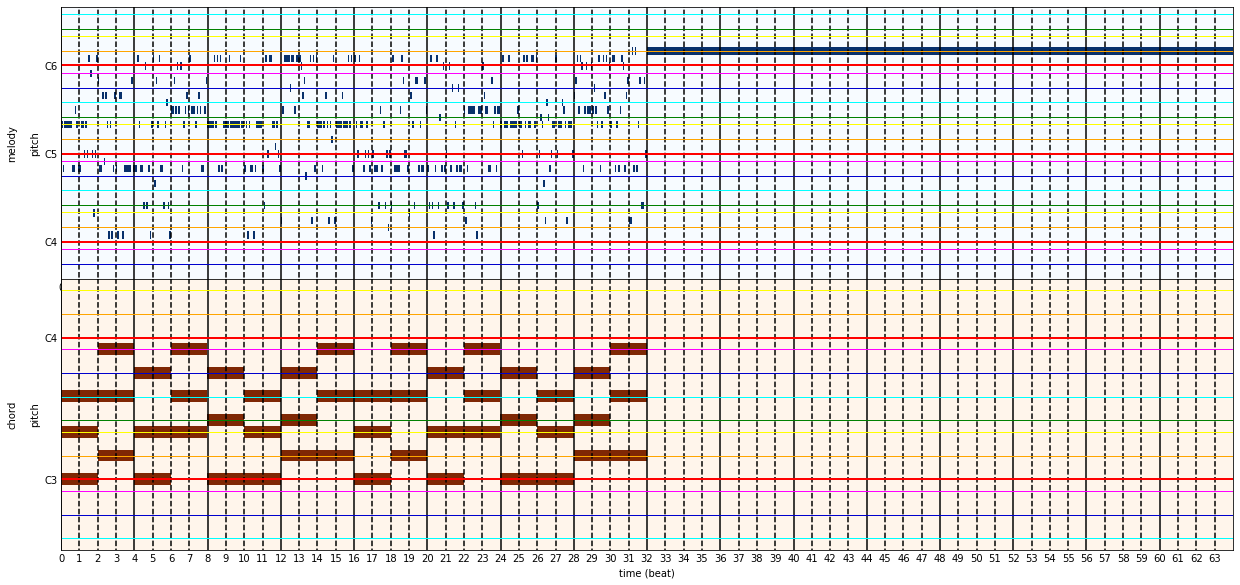

In [13]:
batch_id = 1

g_melody = G.to_ids(g_out).numpy()
bundle = Bundle({
    'melody': g_melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

## SchWBertDiscriminatorの実装

In [10]:
class SchWBertDiscriminator(nn.Module):
    def __init__(self, config, body):
        super(SchWBertDiscriminator, self).__init__()
        self.config = config
        self.body = body
        self.pad_id = config.chord_pad_id
        
        self.head_v = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            GELU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            LayerNorm(config.hidden_size, eps=1e-8),
            GELU(),
            nn.Linear(config.hidden_size, 1),
            GELU(),
        )
        
        self.dense_h = nn.Linear(config.step_num, 1, bias=False)
        # self.sigmoid = nn.Sigmoid() # BCELossに含まれるのでSigmoidしない
    
    def forward_head(self, body_output):
        output = self.head_v(body_output)
        output = output.view(-1, self.config.step_num)
        output = self.dense_h(output)
        # output = self.sigmoid(output)
        return output.view(-1)
            
    def forward(self, input_tensor, condition_tensor, get_all_outputs=False, get_probs=False):
        if get_probs:
            body_output, probs = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output

        output[condition_tensor == self.pad_id] *= 0
        output = self.forward_head(output)
        
        if get_all_outputs:
            output = body_output + output
        
        if get_probs:
            return output, probs
        else:
            return output

動作確認

In [15]:
d_body = make_body(config)
D = SchWBertDiscriminator(config, d_body)

batch = dataloader()
d_out_real = D(batch.melody, batch.chord)
d_out_fake = D(G(batch.chord), batch.chord)

print("real:", d_out_real)
print("fake:", d_out_fake)

real: tensor([-0.1117,  0.0322], grad_fn=<ViewBackward>)
fake: tensor([-0.0606,  0.0657], grad_fn=<ViewBackward>)


# SchW-BERT-GANのファインチューニングの実施
事前学習済みのものとの比較もやる

### モデルの用意

In [11]:
device = torch.device('cuda')
init_bodies = False
multi_gpu = (len(visible_devices) > 1) & (device.type == 'cuda')

if init_bodies:
    print("Use initialized bodies")
    g_body = make_body(config)
    d_body = make_body(config)
else:
    print("Use pre-trained bodies")
    g_body = load_body(config, output_dir)
    d_body = load_body(config, output_dir)

G = SchWBertGenerator(config, g_body)
D = SchWBertDiscriminator(config, d_body)

G, D = G.to(device), D.to(device)

if multi_gpu:
    print("Use Multi GPUs")
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)

g_optim = optim.Adam(G.parameters(), lr=1e-5, betas=(0.5, 0.999))
d_optim = optim.Adam(D.parameters(), lr=1e-5, betas=(0.5, 0.999))

print("Network settings completed")
print("#parameters of G:", count_params(G))
print("#parameters of D:", count_params(D))

Use pre-trained bodies
Use Multi GPUs
Network settings completed
#parameters of G: 1034989
#parameters of D: 1026321


### 学習用データの作成

In [12]:
batch_size = 12
dataloader = TheorytabDataLoader(dataset, batch_size=batch_size, shuffle=True)
print("data num:", len(dataloader.dataset))
print("batch num:", len(dataloader))

data num: 17396
batch num: 1450


## WGAN-gpによる訓練
参考：https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py  
https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py

In [13]:
to_one_hot = torch.eye(config.melody_vocab_size, dtype=torch.float)

def calculate_gradient_penalty(D, real, fake, chord, gp_lambda, device):
    
    # realの方はIDが渡ってくる，interpolates計算のため，one hot化
    real_one_hot = to_one_hot[real].to(device)
    
    # Random Weighted AverageによりRealとFakeの中間テンソルを取得
    eta = torch.empty(len(real), 1, 1).uniform_(0, 1).to(device)
    interpolates = eta * real_one_hot + ((1 - eta) * fake)
    interpolates = interpolates.requires_grad_(True)

    # 中間テンソルをDに通したテンソルを取得
    d_interpolates = D(interpolates, chord)

    # 勾配計算の終端へ与える値？を作成
    grad_outputs = torch.ones((len(real),)).to(device)
    grad_outputs.requires_grad = False
    
    # 勾配ペナルティの計算に使用する勾配を取得
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs, 
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(len(gradients), -1)

    # 勾配ペナルティの計算
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda
    
    return grad_penalty



def train_wgan_gp(G, D, g_optim, d_optim, gtt, dtt, gp_lambda, dataloader, epoch_num, output_dir, device,
              start_epoch=1, report_period=50, save_epoch_period=5, clear_disp_epoch_period=3, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    
    train_turn_table = np.zeros(gtt+dtt, dtype=bool)
    train_turn_table[:dtt] = True
    iteration = 0
    
    G.train()
    D.train()
        
    if get_status_dict:
        status_dict = { 'd_loss_real': [], 'd_loss_fake': [], 'wasserstein_d': [], 'g_loss': [] }

    try:
        total_d_loss_real = 0.0
        total_d_loss_fake = 0.0
        total_wasserstein_d = 0.0
        total_g_loss = 0.0
        
        for epoch in range(start_epoch, epoch_num+1):
            
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            for batch_iteration, batch in enumerate(dataloader, 1):
                
                # WGANではバッチ数が計算に影響を与える?ため，バッチの切れ端は無視する
                if (len(batch.melody) != batch_size):
                    continue
                
                real = batch.melody
                chord = batch.chord.to(device)
                
                # Turn tableを回す
                turn = iteration % (gtt+dtt)
                iteration += 1
                
                ############
                # DのTurn
                ############
                if train_turn_table[turn]:
                    D.zero_grad()
                    
                    real = real.to(device)
                                        
                    with torch.set_grad_enabled(True):
                        # realデータに対するLoss
                        d_loss_real = D(real, chord)
                        d_loss_real = d_loss_real.mean()
                        total_d_loss_real += d_loss_real.item()

                        # fakeデータに対するLoss
                        fake = G(chord)
                        d_loss_fake = D(fake, chord)
                        d_loss_fake = d_loss_fake.mean()
                        total_d_loss_fake += d_loss_fake.item()
                        
                        # 勾配ペナルティ
                        gradient_penalty = calculate_gradient_penalty(D, real, fake, chord, gp_lambda, device)

                        # DのLoss全体，および Wasserstein距離を獲得
                        d_loss = d_loss_fake - d_loss_real + gradient_penalty
                        wasserstein_d = d_loss_real - d_loss_fake
                        total_wasserstein_d += wasserstein_d.item()

                        # Dのパラメータを更新
                        d_loss.backward()
                        d_optim.step()
                    
                    if turn == dtt - 1:
                        # Turnの平均の記録
                        status_dict['d_loss_real'].append(total_d_loss_real / dtt)
                        status_dict['d_loss_fake'].append(total_d_loss_fake / dtt)
                        status_dict['wasserstein_d'].append(total_wasserstein_d / dtt)
                        total_d_loss_real = 0.0
                        total_d_loss_fake = 0.0
                        total_wasserstein_d = 0.0
                
                ############
                # GのTurn
                ############
                else:
                    G.zero_grad()

                    with torch.set_grad_enabled(True):
                        g_loss = D(G(chord), chord)
                        g_loss = - g_loss.mean()

                        total_g_loss += g_loss.item()
                        
                        # Gのパラメータを更新
                        g_loss.backward()
                        g_optim.step()
                    
                    if turn == (gtt + dtt) - 1:
                        # Turnの平均の記録
                        status_dict['g_loss'].append(total_g_loss / gtt)
                        total_g_loss = 0.0
                
                ####################
                # IterationのReport
                ####################
                if (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>5}/{batch_num:<5} | D real: {d_loss_real:.6f} | D fake: {d_loss_fake:.6f} | WD: {wasserstein_d:.6f} | G loss: {g_loss:.6f} | {duration:.4f} [sec]")
                    t_iter_start = time.time()


            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            
            last_d_loss_real = status_dict['d_loss_real'][-1]
            last_d_loss_fake = status_dict['d_loss_fake'][-1]
            last_wasserstein_d = status_dict['wasserstein_d'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            print(f"Epoch {epoch:>3} / {epoch_num:<3} Last Scores | D real: {last_d_loss_real:.6f} | D fake: {last_d_loss_fake:.6f} | WD: {last_wasserstein_d:.6f} | G loss: {last_g_loss:.6f}")
            
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(config, G, epoch, output_dir)
                save_model(config, D, epoch, output_dir)
                print("")

        print("All Fine-Tuning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

訓練の実行

In [ ]:
epoch_num = 10
G_trained, D_trained, status_dict = train_wgan_gp(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    gtt=config.gtt, dtt=config.dtt,
    gp_lambda=config.gp_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    output_dir=output_dir,
    device=device,
    start_epoch=1,
    report_period=len(dataloader) // 10,
    save_epoch_period = 100
)

----- Epoch   1 / 10  start -----


Statusグラフの表示

In [16]:
def show_status_graph_wgan_gp(status_dict, title="Score graphs of WGAN-gp"):
    d_loss_real = status_dict['d_loss_real']
    d_loss_fake = status_dict['d_loss_fake']
    wasserstein_d = status_dict['wasserstein_d']
    g_loss = status_dict['g_loss']
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    x = np.arange(len(d_loss_real))
    axs[0].plot(x, d_loss_real, label='real', linewidth=1.5)
    axs[0].plot(x, d_loss_fake, label='fake', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('turn')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"D losses")

    axs[1].plot(x, wasserstein_d, label='wasserstein_d', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('turn')
    axs[1].set_ylabel('wasserstein_d')
    axs[1].set_title(f"Wasserstein distance")
    
    x = np.arange(len(g_loss))
    axs[2].plot(x, g_loss, label='loss', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('turn')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G loss")

    plt.show()

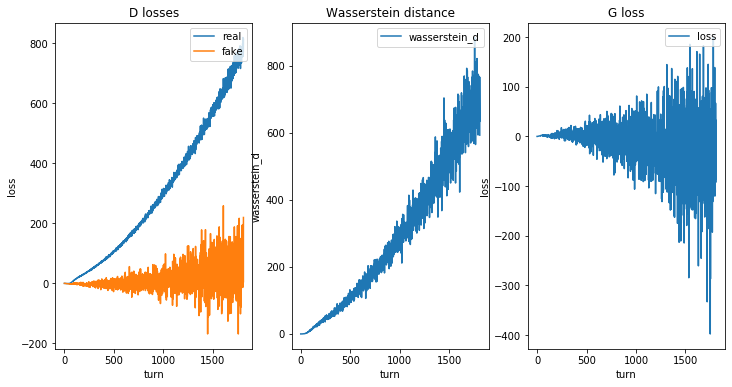

In [17]:
show_status_graph_wgan_gp(status_dict)

記念すべき初回実行  
とりあえず学習済みのbase  
ロクなものではない  
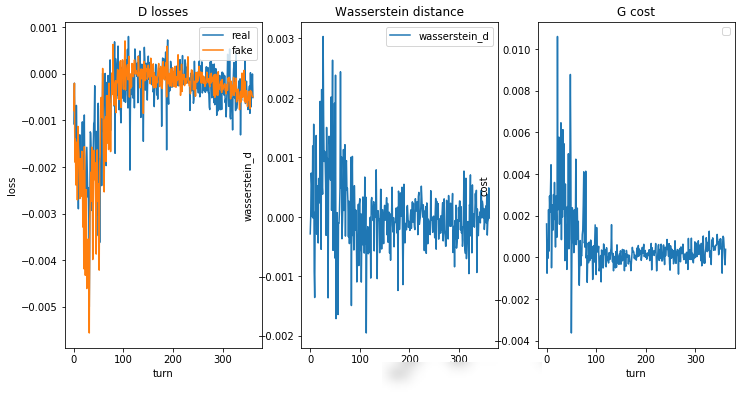

学習しないでやってみた場合  
WDがほぼ0だったりマイナスになったり，謎現象発生中  
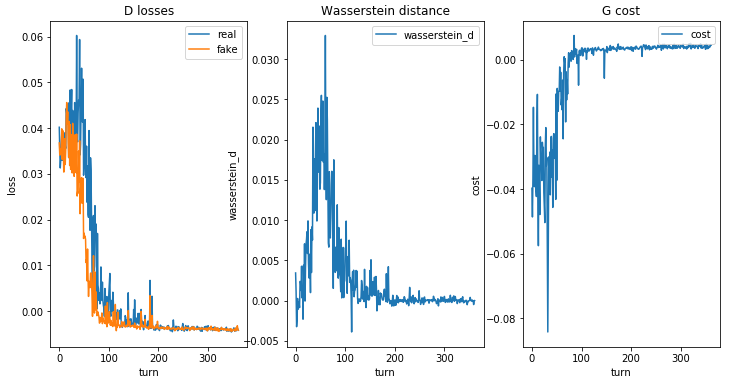

プログラム直してみたらWDの値とかが良い感じになった．  
しかしD強め？みたいなのでgtt3くらいにしてみるか？  
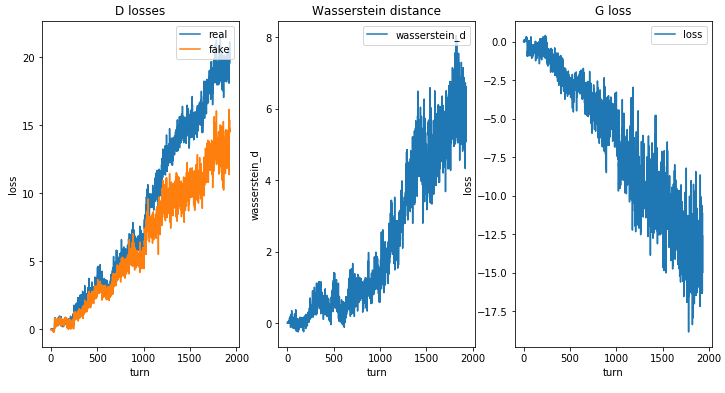

さらにMNP＋MSPの事前学習済みモデルをそのまま使えるようにしたバージョン  
全然Convergeしない．．．  
チューニング実験しながら論文読むか．．．  
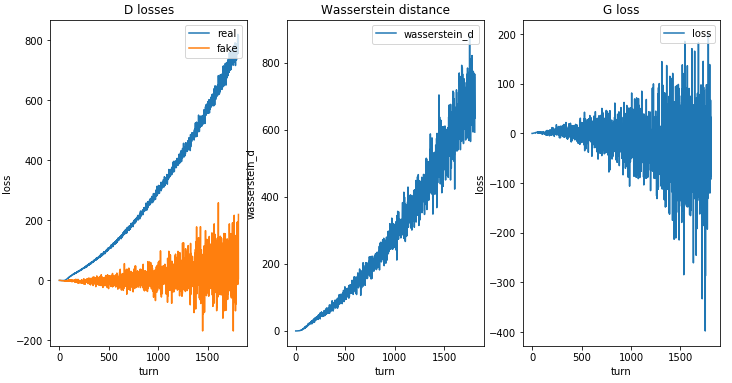

生成データの確認

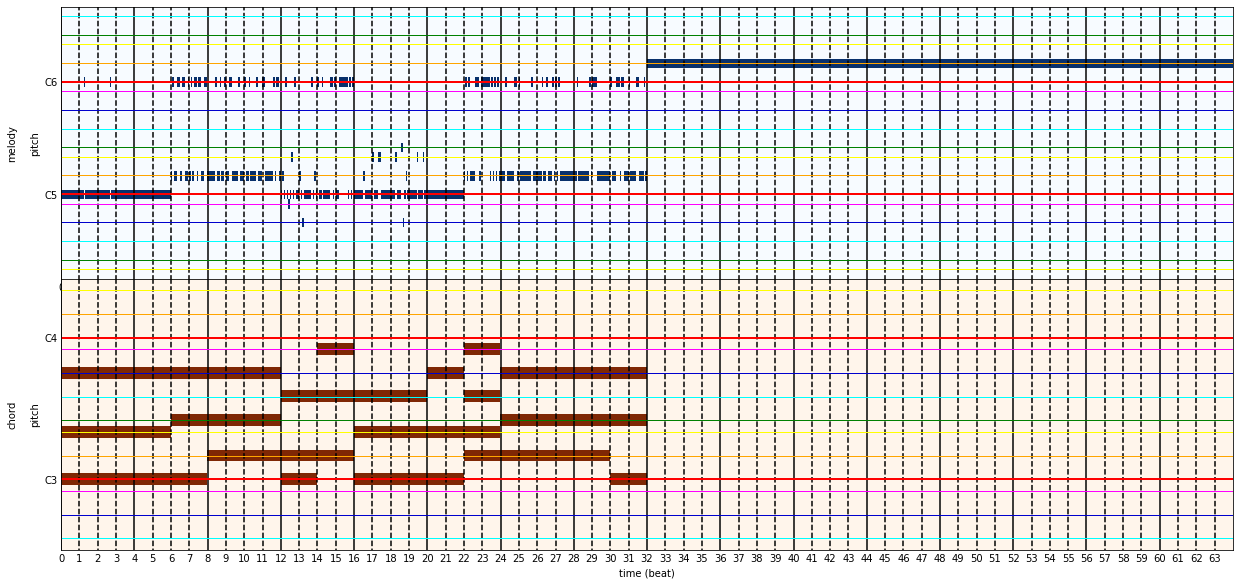

In [18]:
batch = dataloader()
batch_id = 0

g_out = G_trained(batch.chord.to(device))
g_melody = G_trained.to_ids(g_out).cpu().numpy()

bundle = Bundle({
    'melody': g_melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})

bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

初回実行ではこんな感じか…  
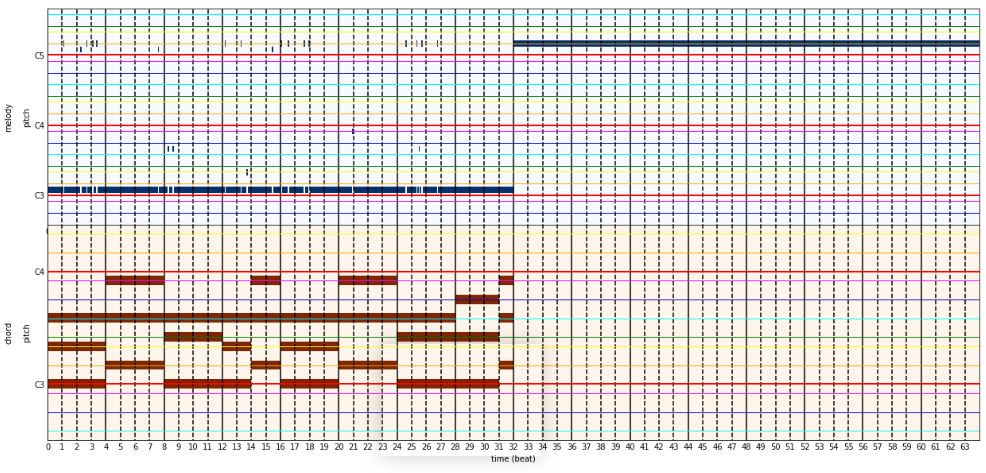

まぁ学習あったほうがバラバラにはならないみたいね  
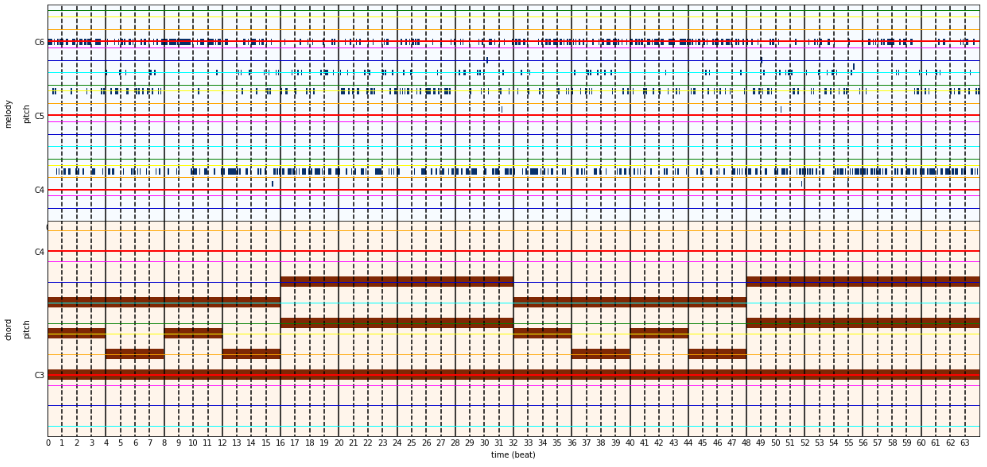

## 通常のGANによる訓練

In [15]:
# G, Dはあらかじめdeviceへ渡されているものとする(使い勝手的に．Deviceの準備時間かかるので)
def train_gan(G, D, g_optim, d_optim, dataloader, epoch_num, output_dir, device,
              start_epoch=1, report_period=50, save_epoch_period=5, clear_disp_epoch_period=3, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)

    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    G.train()
    D.train()
    
    ones = torch.ones(dataloader.batch_size).to(device)
    zeros = torch.zeros(dataloader.batch_size).to(device)
    
    if get_status_dict:
        status_dict = { 'g_loss': [], 'd_loss': [], "d_acc_real": [], "d_acc_fake": []}
        
    
    try:
        for epoch in range(start_epoch, epoch_num+1):

            t_epoch_start = time.time()
            t_iter_start = time.time()

            total_g_loss = 0.0
            total_d_loss = 0.0
            total_d_acc_real = 0.0
            total_d_acc_fake = 0.0

            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            for iteration, batch in enumerate(dataloader, 1):
                
                batch_size = len(batch.melody)
                label_real = ones[:batch_size]
                label_fake = zeros[:batch_size]

                # 使用するのはmelodyのone-hotなのでmelodyはdeviceへ渡さない
                batch.chord = batch.chord.to(device)
                
                #################
                # Discriminator
                #################
                d_optim.zero_grad()
                g_optim.zero_grad()
                
                with torch.set_grad_enabled(True):
                    # 本物の画像と偽物の画像を判定
                    d_out_real = D(batch.melody, batch.chord)
                    d_out_fake = D(G(batch.chord), batch.chord)

                    # 誤差を計算
                    d_loss_real = criterion(d_out_real, label_real)
                    d_loss_fake = criterion(d_out_fake, label_fake)
                    d_loss = d_loss_real + d_loss_fake

                    # 誤差逆伝搬
                    d_loss.backward()
                    d_optim.step()
                
                # 記録
                d_loss_batch = d_loss.item()
                d_acc_real = (d_out_real.cpu() >= 0.5).sum() / batch_size
                d_acc_fake = (d_out_fake.cpu() <  0.5).sum() / batch_size
                
                total_d_loss += d_loss_batch
                total_d_acc_real += d_acc_real
                total_d_acc_fake += d_acc_fake


                #################
                # Generator
                #################
                d_optim.zero_grad()
                g_optim.zero_grad()
                
                with torch.set_grad_enabled(True):
                    # 偽の画像を生成して判定
                    d_out_fake = D(G(batch.chord), batch.chord)

                    # 誤差を計算
                    g_loss = criterion(d_out_fake, label_real)

                    # 誤差逆伝搬
                    g_loss.backward()
                    g_optim.step()
                
                # 記録
                g_loss_batch = g_loss.item()
                total_g_loss += g_loss_batch


                #################
                # Report
                #################                
                if (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {iteration:>5}/{batch_num:<5} | G loss: {g_loss_batch:.6f} | D loss: {d_loss_batch:.6f} | D real: {d_acc_real:.2f} | D fake: {d_acc_fake:.2f} | {duration:.4f} [sec]")
                    t_iter_start = time.time()

            d_loss_epoch = total_d_loss / batch_num
            g_loss_epoch = total_g_loss / batch_num
            d_acc_real_epoch = total_d_acc_real / batch_num
            d_acc_fake_epoch = total_d_acc_fake / batch_num
            print(f"Epoch {epoch:>3} / {epoch_num:<3} Average | G loss: {g_loss_epoch:.6f} | D loss: {d_loss_epoch:.6f} | D real: {d_acc_real_epoch:.2f} | D fake: {d_acc_fake_epoch:.2f}\n")
            
            if get_status_dict:
                status_dict['g_loss'].append(g_loss_epoch)
                status_dict['d_loss'].append(d_loss_epoch)
                status_dict['d_acc_real'].append(d_acc_real_epoch)
                status_dict['d_acc_fake'].append(d_acc_fake_epoch)
            
            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
                
            # チェックポイントモデルの保存
            if (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(config, G, epoch, output_dir)
                save_model(config, D, epoch, output_dir)
                print("")

        print("All Fine-Tuning Finished!")
    
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

In [16]:
epoch_num = 10
G_trained, D_trained, status_dict = train_gan(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    dataloader=dataloader,
    epoch_num=epoch_num,
    output_dir=output_dir,
    device=device,
    start_epoch=1,
    report_period=len(dataloader) // 10,
    save_epoch_period = 100
)

----- Epoch   1 / 2   start -----
Iteration   174/1740  | G loss: 0.692269 | D loss: 1.386059 | D real: 0.00 | D fake: 1.00 | 92.3964 [sec]
Iteration   348/1740  | G loss: 0.701924 | D loss: 1.385101 | D real: 0.00 | D fake: 1.00 | 84.7529 [sec]
Iteration   522/1740  | G loss: 0.730014 | D loss: 1.381317 | D real: 0.00 | D fake: 1.00 | 84.1860 [sec]
Iteration   696/1740  | G loss: 0.755109 | D loss: 1.370781 | D real: 0.00 | D fake: 1.00 | 84.0774 [sec]
Iteration   870/1740  | G loss: 0.869681 | D loss: 1.315900 | D real: 0.00 | D fake: 1.00 | 85.0961 [sec]
Iteration  1044/1740  | G loss: 1.265704 | D loss: 1.218512 | D real: 0.00 | D fake: 1.00 | 84.6513 [sec]
Iteration  1218/1740  | G loss: 1.289320 | D loss: 1.125991 | D real: 0.00 | D fake: 1.00 | 83.8274 [sec]
Keyboard interrupted, but return models.


Statusグラフの表示

In [14]:
def show_status_graph_gan(status_dict, title="A loss graph of G and D"):
    g_loss = status_dict['g_loss']
    d_loss = status_dict['d_loss']
    d_acc_real = status_dict['d_acc_real']
    d_acc_fake = status_dict['d_acc_fake']
    x = np.arange(len(g_loss))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
    axs[0].plot(x, g_loss, label='G', linewidth=1.5)
    axs[0].plot(x, d_loss, label='D', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Loss")

    axs[1].plot(x, d_acc_real, label='real', linewidth=1.5)
    axs[1].plot(x, d_acc_fake, label='fake', linewidth=1.5)
    axs[1].legend(loc='lower right')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('acc')
    axs[1].set_title(f"Acc of D")

    plt.show()

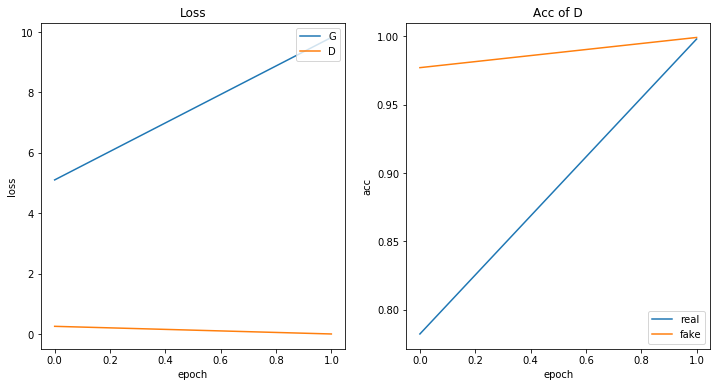

In [23]:
show_status_graph_gan(status_dict)

生成データの確認

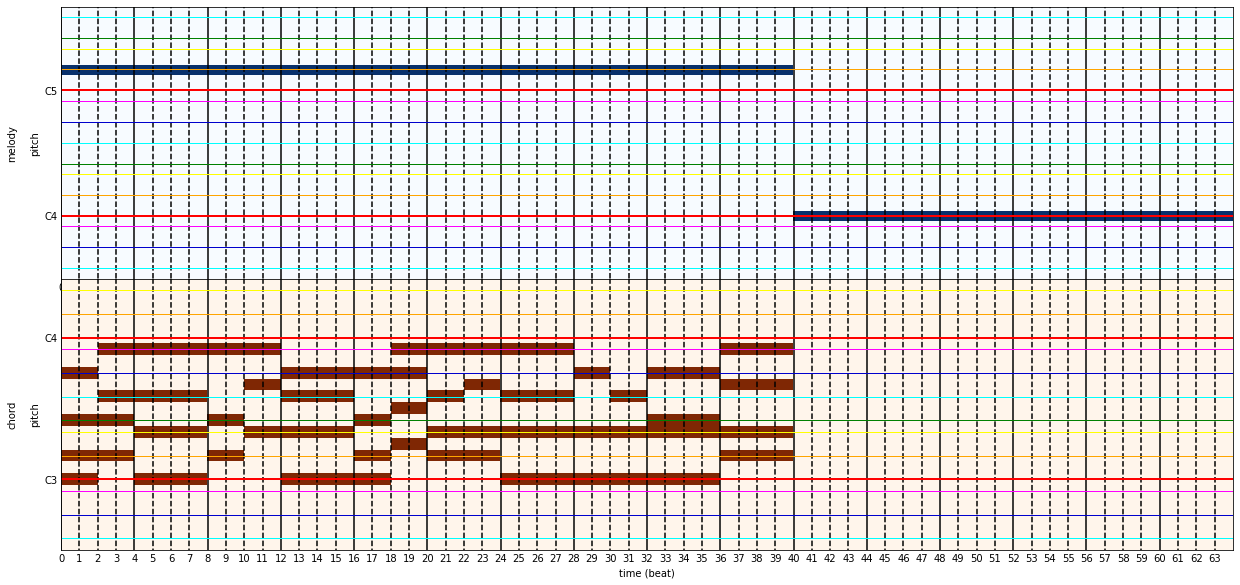

In [25]:
batch = dataloader()
batch_id = 0

g_out = G_trained(batch.chord.to(device))
g_melody = G_trained.to_ids(g_out).cpu().numpy()

bundle = Bundle({
    'melody': g_melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})

bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

通常のGAN，Gが手も足も出ない